### Three connected nodes

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding/")

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate, simulate_delayed

In [3]:
jax.config.update("jax_platform_name", "cpu")

In [4]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [5]:
from scipy.special import gamma


def alpha_function(t, alpha, tau_decay):
    """
    Generates an alpha function as the envelope.
    """
    return (
        (alpha) * np.exp(-t / tau_decay) / (tau_decay * (alpha + 1) * gamma(alpha + 1))
    )


def evoked_potential(t, A, f_initial, f_final, t_transition, alpha, tau_decay):
    # Initialize the signal
    signal = np.zeros_like(t)

    # Time after the transition point (where the stimulus starts)
    stimulus_start_idx = t >= t_transition
    t_stimulus = t[stimulus_start_idx] - t_transition  # Time after stimulus start

    # Frequency decay over time
    freq_t = f_initial + (f_final - f_initial) * t_stimulus / t_max

    # Oscillatory signal with frequency decay
    oscillatory_signal = A * np.cos(2 * np.pi * freq_t * t_stimulus)

    # Apply the alpha envelope to the oscillatory signal
    envelope = alpha_function(t_stimulus, alpha, tau_decay)

    # Combine the oscillatory signal with the decaying envelope
    signal[stimulus_start_idx] = oscillatory_signal * envelope

    return signal

In [6]:
cm = 1 / 2.54

#### Simulation parameters

In [22]:
Nareas = 3
ntrials = 300
fsamp = 1 / 1e-4

time = np.arange(-4, 4, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 20

C = np.array([[0, 1, 0], [0, 0, 1], [0, 0, 0]]).T

In [23]:
C

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [24]:
t_max = time.max()  # Maximum time (in seconds)
dt = 1 / fsamp  # Time step (in seconds)

A = 0.5  # Initial amplitude of the stimulus
f_initial = 20  # Initial frequency of the oscillation (60 Hz)
f_final = 5  # Final frequency after decay (e.g., 10 Hz)
t_transition = 0  # Time at which the stimulus starts (1s after baseline)
alpha = 0.5  # Shape parameter of the alpha function
tau_decay = 0.5  # Time constant for the alpha function

In [25]:
Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 0.4)] = 0.5
# Iext[1, (time >= .3) & (time <= 0.7)] = 0.5
Amplitudes = np.linspace(0, 0.1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [26]:
"""
I_t = evoked_potential(time, A, f_initial, f_final, t_transition, alpha, tau_decay)

Iext = np.zeros((Nareas, Npoints))
Iext[0, :] = I_t
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)
""";

In [27]:
simulate_loop = jax.vmap(
    simulate,
    in_axes=(None, None, None, None, None, None, None, 0, 0, None, None, None),
)

In [28]:
out = simulate_loop(
    C,
    30,
    40,
    jnp.array([-5, -5, -5]),
    fsamp,
    beta,
    Npoints,
    CS,
    seeds,
    "cpu",
    decim,
    "both",
)


stim = np.arange(ntrials)
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(stim, ["x", "y", "z"], time[::decim]),
).sel(times=slice(-2, 2))

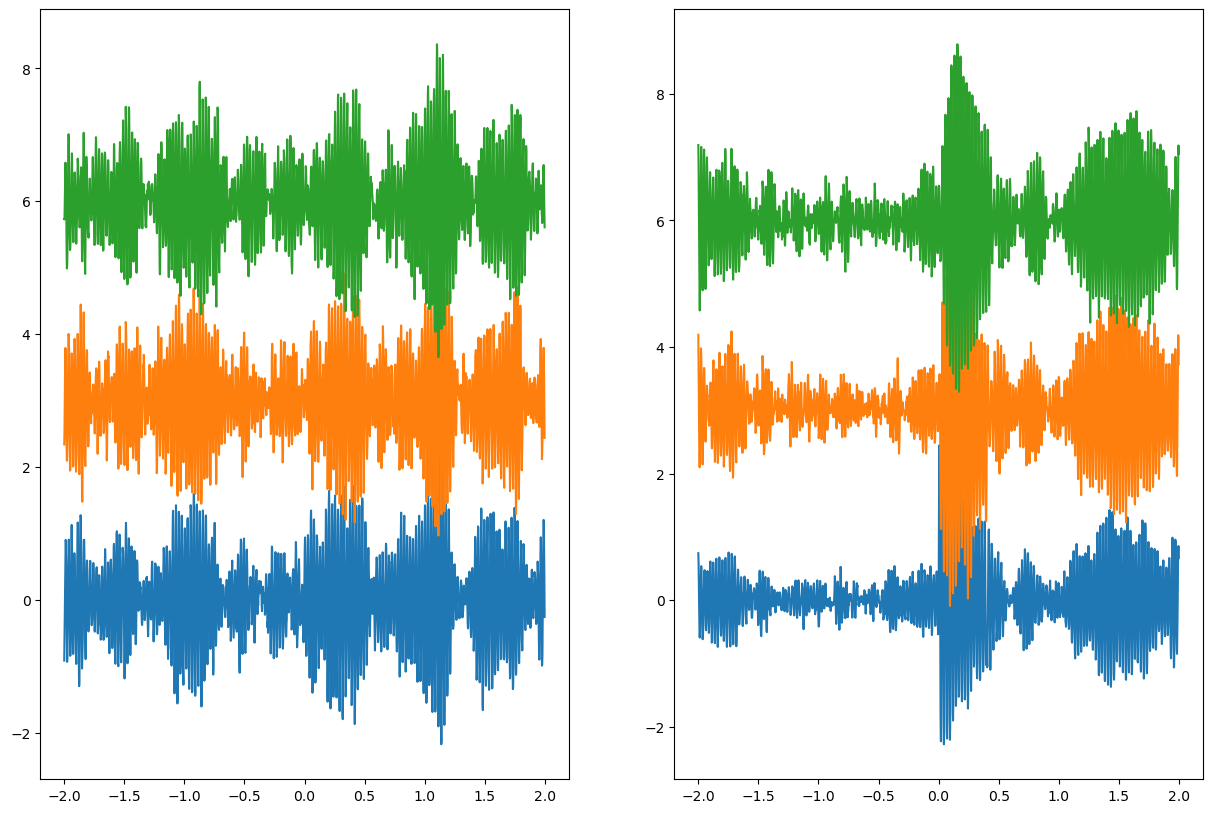

In [29]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

In [30]:
import scipy
from frites.core import (
    copnorm_nd,
    gccmi_nd_ccc,
    gcmi_1d_cc,
    gcmi_model_nd_cd,
    gcmi_nd_cc,
)

In [31]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

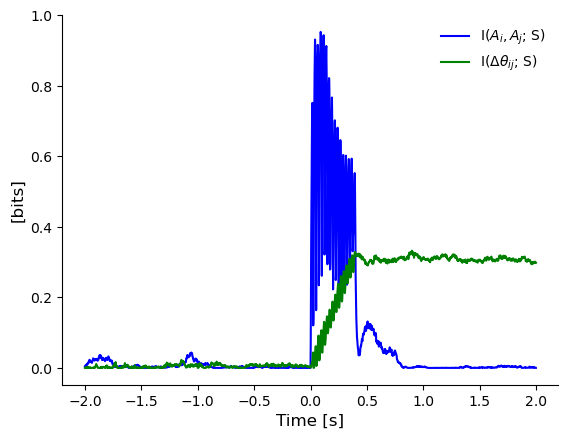

In [32]:
labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])
z = data[:, 0] * np.conj(data[:, 1])
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

I_S_R1 = mi_fcn_time(A[None], labels[None], False, True)
I_S_R2 = mi_fcn_time(dphi[None], labels[None], False, True)
I_S_R12 = mi_fcn_time(dphi[None], labels[None], False, True)

ax = plt.subplot(111)
plt.plot(data.times, I_S_R1, "b")
plt.plot(data.times, I_S_R2, "g")

plt.legend(
    [
        r"I($A_{i}, A_{j}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.savefig("figures/sample_encoding_evoked_potential.png", bbox_inches="tight")

In [33]:
def get_red_syn(data):

    labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])

    E1_amp = np.abs(data[:, 0] * np.conj(data[:, 1])).data
    E2_amp = np.abs(data[:, 1] * np.conj(data[:, 2])).data

    I_S_R1_amp = mi_fcn_time(E1_amp[None], labels[None], False, True)
    I_S_R2_amp = mi_fcn_time(E2_amp[None], labels[None], False, True)
    I_S_R12_amp = mi_fcn_time(np.stack((E1_amp, E2_amp)), labels[None], False, True)

    E1_phi = np.unwrap(np.angle(data[:, 0] * np.conj(data[:, 1])))
    E2_phi = np.unwrap(np.angle(data[:, 1] * np.conj(data[:, 2])))

    I_S_R1_phi = mi_fcn_time(E1_phi[None], labels[None], False, True)
    I_S_R2_phi = mi_fcn_time(E2_phi[None], labels[None], False, True)
    I_S_R12_phi = mi_fcn_time(np.stack((E1_phi, E2_phi)), labels[None], False, True)

    red_amp = I_S_R12_amp - np.minimum(I_S_R1_amp, I_S_R2_amp)
    syn_amp = I_S_R12_amp - np.maximum(I_S_R1_amp, I_S_R2_amp)

    red_phi = I_S_R12_phi - np.minimum(I_S_R1_phi, I_S_R2_phi)
    syn_phi = I_S_R12_phi - np.maximum(I_S_R1_phi, I_S_R2_phi)

    return red_amp, syn_amp, red_phi, syn_phi

In [34]:
red_amp_1, syn_amp_1, red_phi_1, syn_phi_1 = get_red_syn(data)

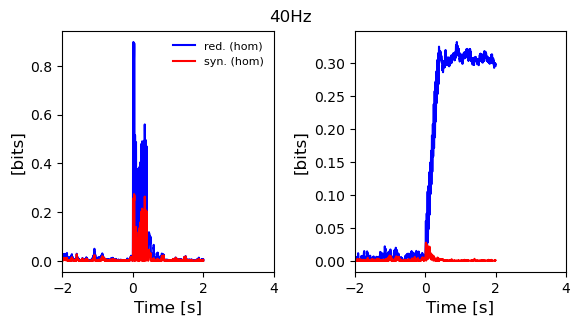

In [35]:
plt.figure(figsize=(15 * cm, 8 * cm))
plt.subplot(121)
plt.plot(data.times, red_amp_1, "b", label="red. (hom)")
plt.plot(data.times, syn_amp_1, "r", label="syn. (hom)")
plt.xlim(-2, 4)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
plt.legend(frameon=False, fontsize=8)

plt.subplot(122)

plt.plot(data.times, red_phi_1, "b")
plt.plot(data.times, syn_phi_1, "r")
plt.xlim(-2, 4)
plt.xlabel("Time [s]", fontsize=12)

plt.ylabel("[bits]", fontsize=12)
plt.tight_layout()
plt.suptitle("40Hz", fontsize=12, y=1.02)

plt.savefig("figures/3nodes_red_syn.png", bbox_inches="tight")

In [ ]:
data = []

for i in tqdm(range(100)):
    seeds = np.random.randint(0, 10000, ntrials)
    out = simulate_loop(
        C,
        10,
        40,
        jnp.array([-5, -5, -10]),
        fsamp,
        beta,
        Npoints,
        CS,
        seeds,
        "cpu",
        decim,
        "both",
    )

    stim = np.arange(ntrials)
    data += [
        xr.DataArray(
            np.stack(out),
            dims=("trials", "roi", "times"),
            coords=(stim, ["x", "y", "z"], time[::decim]),
        ).sel(times=slice(-2, 2))
    ]

  1%|▍                                          | 1/100 [00:07<12:04,  7.32s/it]

In [23]:
red_amp_1, syn_amp_1, red_phi_1, syn_phi_1 = [], [], [], []
for data_ in tqdm(data):
    out = get_red_syn(data_)
    red_amp_1 += [out[0]]
    syn_amp_1 += [out[1]]
    red_phi_1 += [out[2]]
    syn_phi_1 += [out[3]]

100%|█████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


In [29]:
red_amp_1 = np.stack(red_amp_1).mean(0) 
syn_amp_1 = np.stack(syn_amp_1).mean(0) 
red_phi_1 = np.stack(red_phi_1).mean(0) 
syn_phi_1 = np.stack(syn_phi_1).mean(0) 

Text(0.5, 1.02, '40Hz')

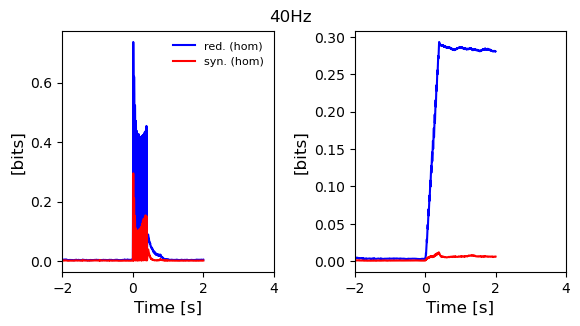

In [31]:
plt.figure(figsize=(15 * cm, 8 * cm))
plt.subplot(121)
plt.plot(data[0].times, red_amp_1, "b", label="red. (hom)")
plt.plot(data[0].times, syn_amp_1, "r", label="syn. (hom)")
plt.xlim(-2, 4)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
plt.legend(frameon=False, fontsize=8)

plt.subplot(122)

plt.plot(data[0].times, red_phi_1, "b")
plt.plot(data[0].times, syn_phi_1, "r")
plt.xlim(-2, 4)
plt.xlabel("Time [s]", fontsize=12)

plt.ylabel("[bits]", fontsize=12)
plt.tight_layout()
plt.suptitle("40Hz", fontsize=12, y=1.02)